In [1]:
# Importation des bibs  necessaires
from pyspark import SparkContext 
from pyspark.sql.functions import unix_timestamp, col, to_date, to_timestamp
from pyspark.streaming import StreamingContext 
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import findspark
findspark.init('/home/vboxuser/spark-3.3.1-bin-hadoop3')

In [2]:
# Créer une session Spark
spark = SparkSession.builder.appName('big_Data').getOrCreate()

In [3]:
# Charger les données CSV à partir de l'HDFS dans un DataFrame Spark
uri = "hdfs://localhost:9870/bouyardan/yellow_tripdata_2016-01.csv"
df = spark.read.format("csv")\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .load(uri)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2016-03-01 00:00:00|  2016-03-01 00:07:55|              1|          2.5|-73.97674560546875| 40.76515197753906|         1|    

In [6]:
df.describe()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, pickup_longitude: string, pickup_latitude: string, RatecodeID: string, store_and_fwd_flag: string, dropoff_longitude: string, dropoff_latitude: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string]

In [4]:
# Supprimer les colonnes inutiles
df = df.drop('VendorID', 'RatecodeID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge')

# Éliminer les lignes avec des données manquantes
df = df.na.drop()

# Convertir les colonnes de date/heure en format datetime
df = df.withColumn('tpep_pickup_datetime', to_timestamp(col('tpep_pickup_datetime'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn('tpep_dropoff_datetime', to_timestamp(col('tpep_dropoff_datetime'), 'yyyy-MM-dd HH:mm:ss'))

# Afficher les 5 premières lignes
df.show(5)


+--------------------+---------------------+---------------+-------------+------------------+------------------+------------------+-----------------+------------+-----------+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|payment_type|fare_amount|tip_amount|total_amount|
+--------------------+---------------------+---------------+-------------+------------------+------------------+------------------+-----------------+------------+-----------+----------+------------+
| 2016-03-01 00:00:00|  2016-03-01 00:07:55|              1|          2.5|-73.97674560546875| 40.76515197753906|-74.00426483154297|40.74612808227539|           1|        9.0|      2.05|       12.35|
| 2016-03-01 00:00:00|  2016-03-01 00:11:06|              1|          2.9|-73.98348236083984| 40.76792526245117|-74.00594329833984| 40.7331657409668|           1|       11.0|      3.05|       15.35|
| 201

In [5]:
# Calculer la durée de chaque trajet en secondes
df=df.withColumn("trip_duration_seconds",(unix_timestamp(col("tpep_dropoff_\
                                                             datetime"))-unix_timestamp(col("tpep_pickup_datetime"))))


# Calculer la distance en miles pour chaque trajet
df = df.withColumn("trip_distance_miles", col("trip_distance") * 0.621371)

# Calculer la durée du trajet en heures
df = df.withColumn("trip_duration_hours", col("trip_duration_seconds") / 3600)

# Calculer la vitesse moyenne de chaque trajet en miles par heure
df = df.withColumn("average_speed_mph", col("trip_distance_miles") / col("trip_duration_hours"))

# Filtrer les lignes avec des montants de tarif négatifs
df = df.filter(col("fare_amount") >= 0)

# Filtrer les lignes avec des distances de trajet négatives
df = df.filter(col('trip_distance') >= 0)

# Afficher les 10 premieres lignes du DataFrame
df.show(10)


+--------------------+---------------------+---------------+-------------+------------------+------------------+------------------+------------------+------------+-----------+----------+------------+---------------------+-------------------+-------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|tip_amount|total_amount|trip_duration_seconds|trip_distance_miles|trip_duration_hours| average_speed_mph|
+--------------------+---------------------+---------------+-------------+------------------+------------------+------------------+------------------+------------+-----------+----------+------------+---------------------+-------------------+-------------------+------------------+
| 2016-03-01 00:00:00|  2016-03-01 00:07:55|              1|          2.5|-73.97674560546875| 40.76515197753906|-74.00426483154297| 40.74612808227539|       

In [6]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+
|summary|   passenger_count|     trip_distance|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|        tip_amount|      total_amount|trip_duration_seconds|trip_distance_miles|trip_duration_hours| average_speed_mph|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+-------------------+-------------------+------------------+
|  count|             19988|             19988|             19988|             19988|             19988|             19988|             19988|             19

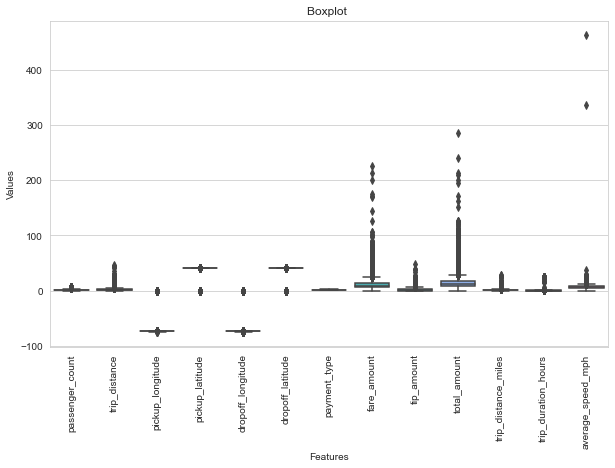

In [7]:
# Sélectionner les colonnes
df_select = df.select("passenger_count","trip_distance","pickup_longitude","pickup_latitude",
                      "dropoff_longitude","dropoff_latitude","payment_type","fare_amount","tip_amount",
                      "total_amount","trip_distance_miles","trip_duration_hours", "average_speed_mph")

# Convertir le dataframe en Pandas pour utiliser seaborn
df_pandas = df_select.toPandas()

# Créer un boxplot en utilisant seaborn et matplotlib
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_pandas)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.set_xlabel("Features")
ax.set_ylabel("Values")
ax.set_title("Boxplot ")
plt.show()


In [8]:
# Diviser les données en ensembles d'entraînement et de test
(trainingData, testData) = df.randomSplit([0.7, 0.3])

# Créer le vecteur de caractéristiques
assembler = VectorAssembler(inputCols=['passenger_count','pickup_latitude', 'trip_distance','pickup_longitude',
                                       'fare_amount','trip_duration_hours','payment_type','dropoff_longitude',
                                       'tip_amount' ], outputCol='features')
trainingData = assembler.transform(trainingData)
testData = assembler.transform(testData)

# Créer le modèle
lr = LinearRegression(featuresCol='features', labelCol='total_amount', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Entraîner le modèle sur les données d'entraînement
lrModel = lr.fit(trainingData)

# Faire des prédictions sur les données de test et train
test_predictions = lrModel.transform(testData)
train_predictions = lrModel.transform(trainingData)

# Afficher les prédictions et les vraies valeurs
test_predictions.select('prediction', 'total_amount').show()
train_predictions.select('prediction', 'total_amount').show()

+------------------+------------+
|        prediction|total_amount|
+------------------+------------+
| 8.272617111973767|         8.8|
| 28.70188861544968|        28.0|
|  9.02909327558025|         9.3|
|11.565535151346007|        11.8|
| 34.88987856729224|       33.96|
|10.806303175634994|       11.16|
| 11.59104236129869|       11.76|
| 14.37790045562699|        14.3|
|  69.1940937972786|        66.0|
|14.598568778073943|       14.76|
|11.966840842661771|       12.35|
|13.925698942389392|       14.15|
| 8.410578826231381|         8.8|
| 7.488523927939549|         7.8|
|12.245980650094129|        12.3|
|15.849545250365827|        16.0|
|12.231660709483826|        12.5|
|10.338351305893427|        10.3|
|15.295047303163336|        15.3|
|19.602968627005996|       19.56|
+------------------+------------+
only showing top 20 rows

+------------------+------------+
|        prediction|total_amount|
+------------------+------------+
| 38.10091389707991|       41.62|
|30.041922192568858|  

In [9]:
# Évaluer les performances du modèle sur les données de test
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
test_rmse = evaluator.evaluate(test_predictions)
mae_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
mse_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "mse"})
r2_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

# Évaluer les performances du modèle sur les données de train
train_rmse = evaluator.evaluate(train_predictions)
mae_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
mse_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "mse"})
r2_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "r2"})

# Afficher toutes les métriques d'évaluation
print('RMSE test:', test_rmse)
print('RMSE train:', train_rmse)
print('MSE test:', mse_test)
print('MSE train:', mse_train)
print('MAE test:', mae_test)
print('MAE train:', mae_train)
print('R2 test:', r2_test)
print('R2 train:', r2_train)


RMSE test: 1.1516315605224319
RMSE train: 1.0780715766944804
MSE test: 1.3262552511913315
MSE train: 1.162238324476523
MAE test: 0.4220673241892999
MAE train: 0.40227187555730787
R2 test: 0.9918409124007224
R2 train: 0.9929529753654044


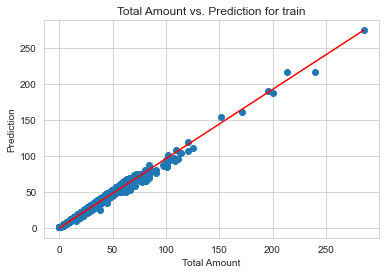

In [10]:
# Sélectionner les colonnes "prediction" et "total_amount" 
df_pred_total = train_predictions.select("prediction", "total_amount")

# Convertir le DataFrame en Pandas DataFrame
pandas_df = df_pred_total.toPandas()

# Afficher un nuage de points pour la colonne "prediction" en fonction de "total_amount"
plt.scatter(pandas_df["total_amount"], pandas_df["prediction"])
plt.xlabel("Total Amount")
plt.ylabel("Prediction")
plt.title("Total Amount vs. Prediction for train")
plt.plot([0, max(pandas_df["total_amount"])], [0, max(pandas_df["prediction"])], '-', color='red')
plt.show()


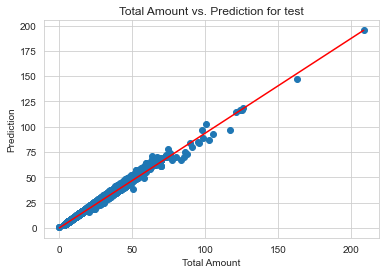

In [11]:
# Sélectionner les colonnes "prediction" et "total_amount" 
df_pred_totall = test_predictions.select("prediction", "total_amount")

# Convertir le DataFrame en Pandas DataFrame
pandas_dff = df_pred_totall.toPandas()

# Afficher un nuage de points pour la colonne "prediction" en fonction de "total_amount"
plt.scatter(pandas_dff["total_amount"], pandas_dff["prediction"])
plt.xlabel("Total Amount")
plt.ylabel("Prediction")
plt.title("Total Amount vs. Prediction for test")
plt.plot([0, max(pandas_dff["total_amount"])], [0, max(pandas_dff["prediction"])], '-', color='red')
plt.show()

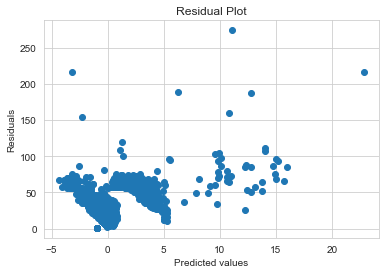

In [12]:
# Tracer un graphique de dispersion des résidus par rapport aux valeurs prédites
summary = lrModel.summary
residuals = summary.residuals.toPandas()
plt.scatter(residuals['residuals'], pandas_df["prediction"])
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()